In [2]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
import pandas as pd

/tmp/ipykernel_1420/4055002814.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace('NC', 0, inplace=True)


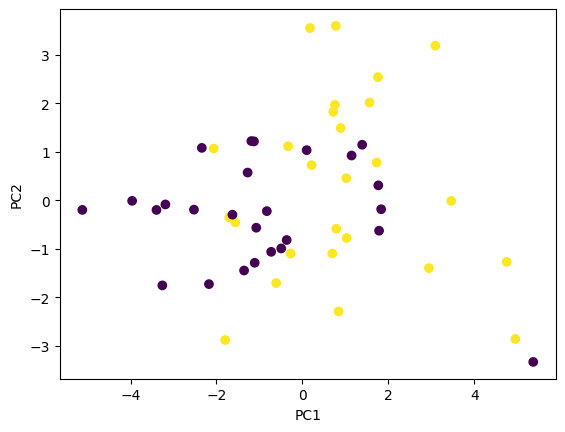

In [8]:
data = pd.read_csv('./qPCR_data.csv', header=0, index_col=0)

# 数据处理和替换
data.replace('HCC', 1, inplace=True)
data.replace('NC', 0, inplace=True)
data = data.fillna(data.median())
data = data.values
x = data[:, :-1]
y = data[:, -1]
x = (x - np.mean(x, axis=0)) / np.std(x, axis=0)

pca = PCA(n_components=2)
pca.fit(x)
x_pca = pca.transform(x)

# PCA降维
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [7]:
# 划分训练集和测试集
np.random.seed(0)
index = np.random.permutation(len(x))
x_train = x[index[:int(len(x)*0.8)]]
y_train = y[index[:int(len(x)*0.8)]]
x_test = x[index[int(len(x)*0.8):]]
y_test = y[index[int(len(x)*0.8):]]

In [5]:
model = LogisticRegression(penalty='l2')
clf = GridSearchCV(model, param_grid={'C': [0.01, 0.1, 1, 10, 100]}, cv=5, scoring='roc_auc', verbose=4)
slector = RFECV(clf, step=1, min_features_to_select=5, cv=5, importance_getter=lambda clf:clf.best_estimator_.coef_, scoring='roc_auc', verbose=4)
slector.fit(x_train, y_train)
mask = slector.support_
print(slector.n_features_)
print(slector.support_)
print(slector.ranking_)

Fitting estimator with 11 features.
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ............................C=0.01;, score=0.833 total time=   0.0s
[CV 2/5] END ............................C=0.01;, score=1.000 total time=   0.0s
[CV 3/5] END ............................C=0.01;, score=0.333 total time=   0.0s
[CV 4/5] END ............................C=0.01;, score=1.000 total time=   0.0s
[CV 5/5] END ............................C=0.01;, score=1.000 total time=   0.0s
[CV 1/5] END .............................C=0.1;, score=0.833 total time=   0.0s
[CV 2/5] END .............................C=0.1;, score=0.917 total time=   0.0s
[CV 3/5] END .............................C=0.1;, score=0.333 total time=   0.0s
[CV 4/5] END .............................C=0.1;, score=1.000 total time=   0.0s
[CV 5/5] END .............................C=0.1;, score=1.000 total time=   0.0s
[CV 1/5] END ...............................C=1;, score=0.833 total time=   0.0s
[CV 2/5] END 

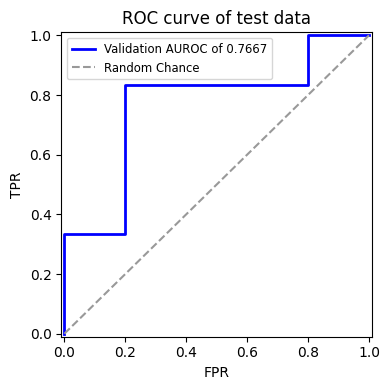

In [6]:
model.fit(np.array([x[mask] for x in x_train]), y_train)
y_pred_proba = model.predict_proba(np.array([x[mask] for x in x_test]))[:,1]
fpr, tpr,_ = roc_curve(y_test, y_pred_proba)
AUROC = auc(fpr, tpr)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, '-', color='b', label='Validation AUROC of {:.4f}'.format(AUROC), lw=2)
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Chance')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.title('ROC curve of test data')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='best',fontsize='small')
plt.tight_layout()
plt.show()
plt.close()